# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [7]:
def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com media=0 e stddev=sqrt(3.0 / (out + inp)). Ver notas de np.random.randn.
    std_dev = np.sqrt(3.0 / (rows + cols))
    return std_dev*np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], onde limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit

# Regularização

###### Dos Pesos

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = np.where(weights < 0, -1, weights)
        return np.where(weights > 0, 1, weights)
    return np.sum(np.abs(weights))

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Implementação 

In [9]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones, dropout_prob=0.0, reg_func=l2_regularization, reg_strength=0.0, is_trainable=True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.is_trainable = is_trainable

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, momentum=0.0):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self.momentum = momentum
        
    def fit(self, x, y, epochs=100, verbose=10):
        for epoch in range(epochs+1):
            y_pred = self.__feedforward(x)
            self.__backprop(y, y_pred)
            
            if epoch % verbose == 0:
                data_loss = self.cost_func(y, self.predict(x))/x.shape[0]
                reg_loss = np.sum([layer.reg_strength*layer.reg_func(layer.weights) for layer in self.layers])
                print("epoch: {0:=4}/{1} data_loss:{2:.8f} reg_loss:{3:.8f} cost:{4:.8f}".format(epoch, epochs, data_loss, reg_loss, data_loss + reg_loss))
        
    def predict(self, x):
        return self.__feedforward(x, is_training=False)
    
    def __feedforward(self, x, is_training=True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            current_layer._dropout_mask = np.random.binomial(1, 1.0-current_layer.dropout_prob, y.shape) / (1.0-current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer._dropout_mask
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)
        
        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + layer.reg_strength*layer.reg_func(layer.weights, derivative=True)
                layer._prev_dweights = -self.learning_rate*layer._dweights + self.momentum*layer._prev_dweights                
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.biases - self.learning_rate*layer._dbiases

# Testes da Implementação

## Exemplos do Notebook da Intuição

### Exemplo 1

In [10]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 data_loss:0.28047145 reg_loss:0.00000000 cost:0.28047145
[[ 0.14978072  0.19956143]
 [ 0.24975114  0.29950229]]
[[ 0.35891648  0.40866619]
 [ 0.51130127  0.56137012]]


### Exemplo 2

In [11]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)
for layer in nn.layers:
    print(layer.weights)

for layer in nn.layers:
    layer.is_trainable = False

print("Trainable == FALSE")
nn.fit(x, y, epochs=1000, verbose=100)
for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 data_loss:1.14054966 reg_loss:0.00000000 cost:1.14054966
epoch:   30/300 data_loss:0.59630022 reg_loss:0.00000000 cost:0.59630022
epoch:   60/300 data_loss:0.36031189 reg_loss:0.00000000 cost:0.36031189
epoch:   90/300 data_loss:0.24668884 reg_loss:0.00000000 cost:0.24668884
epoch:  120/300 data_loss:0.18386202 reg_loss:0.00000000 cost:0.18386202
epoch:  150/300 data_loss:0.14510157 reg_loss:0.00000000 cost:0.14510157
epoch:  180/300 data_loss:0.11918285 reg_loss:0.00000000 cost:0.11918285
epoch:  210/300 data_loss:0.10078511 reg_loss:0.00000000 cost:0.10078511
epoch:  240/300 data_loss:0.08712037 reg_loss:0.00000000 cost:0.08712037
epoch:  270/300 data_loss:0.07660623 reg_loss:0.00000000 cost:0.07660623
epoch:  300/300 data_loss:0.06828531 reg_loss:0.00000000 cost:0.06828531
[[ 0.10083595  0.2016719   0.30585165]
 [ 0.30086971  0.20173942  0.70608796]
 [ 0.40145052  0.30290104  0.91015363]]
[[ 0.20544723  0.30673159  0.50749567]
 [ 0.30994562  0.5123005   0.71366784]
 

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

In [12]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [13]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 1.0


epoch:    0/1000 data_loss:45.88693164 reg_loss:0.00000000 cost:45.88693164
epoch:  100/1000 data_loss:0.31421991 reg_loss:0.00000000 cost:0.31421991
epoch:  200/1000 data_loss:0.26205563 reg_loss:0.00000000 cost:0.26205563
epoch:  300/1000 data_loss:0.26085732 reg_loss:0.00000000 cost:0.26085732
epoch:  400/1000 data_loss:0.26082979 reg_loss:0.00000000 cost:0.26082979
epoch:  500/1000 data_loss:0.26082916 reg_loss:0.00000000 cost:0.26082916
epoch:  600/1000 data_loss:0.26082915 reg_loss:0.00000000 cost:0.26082915
epoch:  700/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
epoch:  800/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
epoch:  900/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
epoch: 1000/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
[[ 33.60164744]]
[[ 74.99636286]]


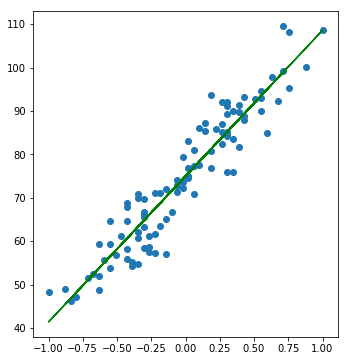

In [14]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [15]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [16]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [ 1.  1.  1.]


In [17]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 data_loss:487.81600963 reg_loss:0.00000000 cost:487.81600963
epoch:  200/2000 data_loss:0.27517416 reg_loss:0.00000000 cost:0.27517416
epoch:  400/2000 data_loss:0.23289119 reg_loss:0.00000000 cost:0.23289119
epoch:  600/2000 data_loss:0.22988983 reg_loss:0.00000000 cost:0.22988983
epoch:  800/2000 data_loss:0.22955986 reg_loss:0.00000000 cost:0.22955986
epoch: 1000/2000 data_loss:0.22951843 reg_loss:0.00000000 cost:0.22951843
epoch: 1200/2000 data_loss:0.22951308 reg_loss:0.00000000 cost:0.22951308
epoch: 1400/2000 data_loss:0.22951239 reg_loss:0.00000000 cost:0.22951239
epoch: 1600/2000 data_loss:0.22951230 reg_loss:0.00000000 cost:0.22951230
epoch: 1800/2000 data_loss:0.22951229 reg_loss:0.00000000 cost:0.22951229
epoch: 2000/2000 data_loss:0.22951229 reg_loss:0.00000000 cost:0.22951229
[[  8.72090863  14.10521538  26.26733328]]
[[ 150.65173403]]


### Regressão Quadrática

In [18]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [19]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/1000 data_loss:22.44648178 reg_loss:0.00000000 cost:22.44648178
epoch:  100/1000 data_loss:4.15033004 reg_loss:0.00000000 cost:4.15033004
epoch:  200/1000 data_loss:1.09803162 reg_loss:0.00000000 cost:1.09803162
epoch:  300/1000 data_loss:0.73118058 reg_loss:0.00000000 cost:0.73118058
epoch:  400/1000 data_loss:0.61010483 reg_loss:0.00000000 cost:0.61010483
epoch:  500/1000 data_loss:0.54491912 reg_loss:0.00000000 cost:0.54491912
epoch:  600/1000 data_loss:0.58950796 reg_loss:0.00000000 cost:0.58950796
epoch:  700/1000 data_loss:0.51944608 reg_loss:0.00000000 cost:0.51944608
epoch:  800/1000 data_loss:0.48311527 reg_loss:0.00000000 cost:0.48311527
epoch:  900/1000 data_loss:0.48979493 reg_loss:0.00000000 cost:0.48979493
epoch: 1000/1000 data_loss:0.45804318 reg_loss:0.00000000 cost:0.45804318


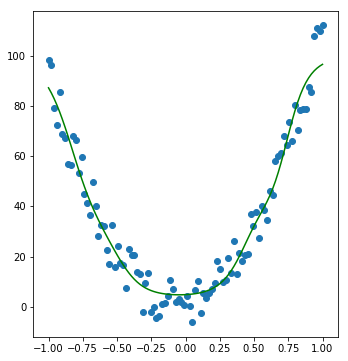

In [20]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [21]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [22]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/1000 data_loss:1.00692221 reg_loss:0.00000000 cost:1.00692221
epoch:  100/1000 data_loss:0.81492377 reg_loss:0.00000000 cost:0.81492377
epoch:  200/1000 data_loss:0.52997805 reg_loss:0.00000000 cost:0.52997805
epoch:  300/1000 data_loss:0.29840470 reg_loss:0.00000000 cost:0.29840470
epoch:  400/1000 data_loss:0.15703519 reg_loss:0.00000000 cost:0.15703519
epoch:  500/1000 data_loss:0.08809791 reg_loss:0.00000000 cost:0.08809791
epoch:  600/1000 data_loss:0.05965674 reg_loss:0.00000000 cost:0.05965674
epoch:  700/1000 data_loss:0.04724515 reg_loss:0.00000000 cost:0.04724515
epoch:  800/1000 data_loss:0.03982024 reg_loss:0.00000000 cost:0.03982024
epoch:  900/1000 data_loss:0.03480806 reg_loss:0.00000000 cost:0.03480806
epoch: 1000/1000 data_loss:0.03154430 reg_loss:0.00000000 cost:0.03154430


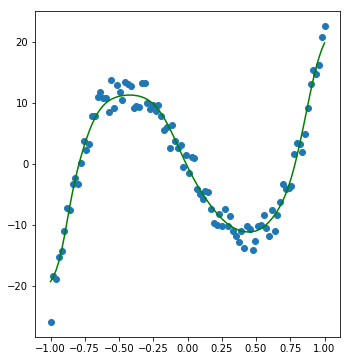

In [23]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [24]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [25]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/1000 data_loss:0.01325889 reg_loss:0.00000000 cost:0.01325889
epoch:  100/1000 data_loss:0.00053807 reg_loss:0.00000000 cost:0.00053807
epoch:  200/1000 data_loss:0.00048307 reg_loss:0.00000000 cost:0.00048307
epoch:  300/1000 data_loss:0.00045823 reg_loss:0.00000000 cost:0.00045823
epoch:  400/1000 data_loss:0.00044400 reg_loss:0.00000000 cost:0.00044400
epoch:  500/1000 data_loss:0.00043471 reg_loss:0.00000000 cost:0.00043471
epoch:  600/1000 data_loss:0.00042804 reg_loss:0.00000000 cost:0.00042804
epoch:  700/1000 data_loss:0.00042289 reg_loss:0.00000000 cost:0.00042289
epoch:  800/1000 data_loss:0.00041869 reg_loss:0.00000000 cost:0.00041869
epoch:  900/1000 data_loss:0.00041512 reg_loss:0.00000000 cost:0.00041512
epoch: 1000/1000 data_loss:0.00041199 reg_loss:0.00000000 cost:0.00041199


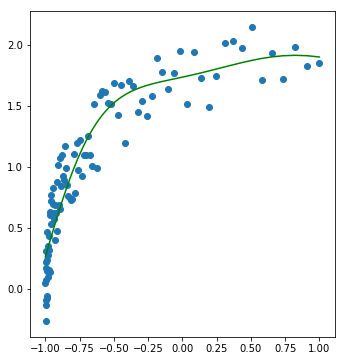

In [26]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-4, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [27]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [28]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/1000 data_loss:15.95011814 reg_loss:0.00000000 cost:15.95011814
epoch:  100/1000 data_loss:0.36931211 reg_loss:0.00000000 cost:0.36931211
epoch:  200/1000 data_loss:0.35261371 reg_loss:0.00000000 cost:0.35261371
epoch:  300/1000 data_loss:0.34417512 reg_loss:0.00000000 cost:0.34417512
epoch:  400/1000 data_loss:0.33760708 reg_loss:0.00000000 cost:0.33760708
epoch:  500/1000 data_loss:0.33330924 reg_loss:0.00000000 cost:0.33330924
epoch:  600/1000 data_loss:0.33069442 reg_loss:0.00000000 cost:0.33069442
epoch:  700/1000 data_loss:0.32933633 reg_loss:0.00000000 cost:0.32933633
epoch:  800/1000 data_loss:0.32868223 reg_loss:0.00000000 cost:0.32868223
epoch:  900/1000 data_loss:0.32836197 reg_loss:0.00000000 cost:0.32836197
epoch: 1000/1000 data_loss:0.32820646 reg_loss:0.00000000 cost:0.32820646


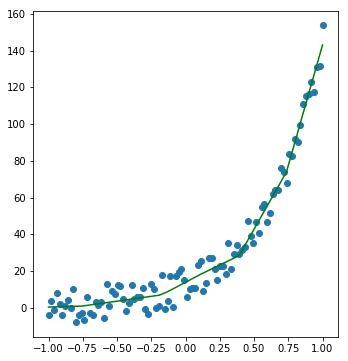

In [29]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [30]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 data_loss:0.23033233 reg_loss:0.06636700 cost:0.29669933
epoch: 1000/5000 data_loss:0.07160600 reg_loss:0.15234694 cost:0.22395294
epoch: 2000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
epoch: 3000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
epoch: 4000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
epoch: 5000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
[[ 1.52346962  1.52346962]] [[-2.63959782]]
Predições:
[[ 0.06663304]
 [ 0.24673017]
 [ 0.24673017]
 [ 0.60045023]]
Acurácia: 100.00%


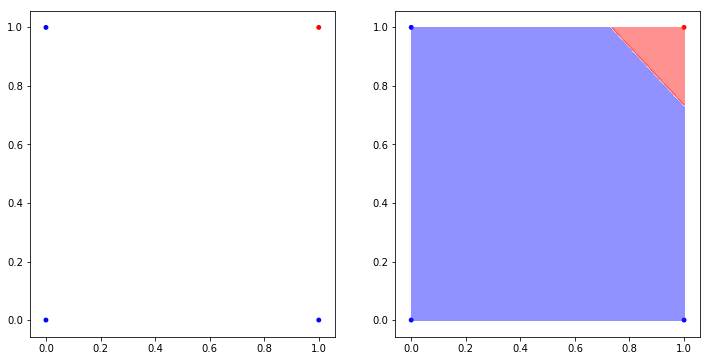

In [31]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid, reg_func=l1_regularization, reg_strength=0.05))

nn.fit(x, y, epochs=5000, verbose=1000)

print(nn.layers[0].weights, nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

In [32]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 data_loss:0.22475154 reg_loss:0.00000000 cost:0.22475154
epoch: 1000/5000 data_loss:0.01141720 reg_loss:0.00000000 cost:0.01141720
epoch: 2000/5000 data_loss:0.00716574 reg_loss:0.00000000 cost:0.00716574
epoch: 3000/5000 data_loss:0.00560594 reg_loss:0.00000000 cost:0.00560594
epoch: 4000/5000 data_loss:0.00474416 reg_loss:0.00000000 cost:0.00474416
epoch: 5000/5000 data_loss:0.00418093 reg_loss:0.00000000 cost:0.00418093
Predições:
[[ 0.0167009 ]
 [ 0.98101229]
 [ 0.98422133]
 [ 0.01486659]]
Acurácia: 100.00%


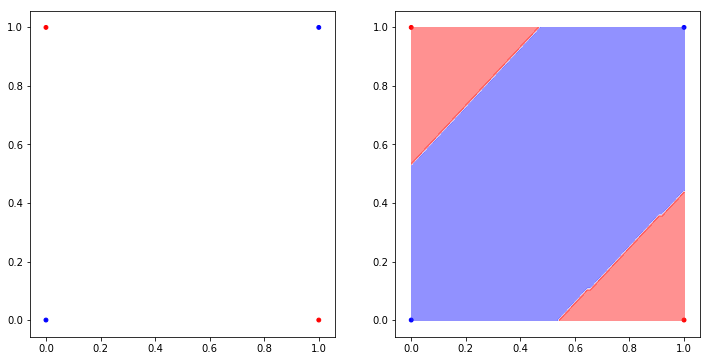

In [33]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

In [34]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 data_loss:0.00025234 reg_loss:0.00000000 cost:0.00025234
epoch: 1000/5000 data_loss:0.00017178 reg_loss:0.00000000 cost:0.00017178
epoch: 2000/5000 data_loss:0.00014931 reg_loss:0.00000000 cost:0.00014931
epoch: 3000/5000 data_loss:0.00013333 reg_loss:0.00000000 cost:0.00013333
epoch: 4000/5000 data_loss:0.00012123 reg_loss:0.00000000 cost:0.00012123
epoch: 5000/5000 data_loss:0.00011166 reg_loss:0.00000000 cost:0.00011166
Acurácia: 100.00%


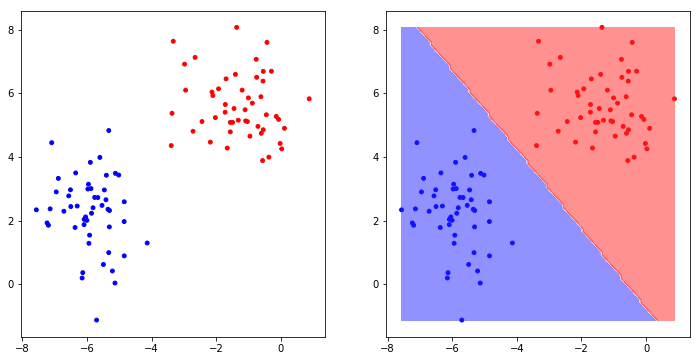

In [35]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 4 Clusters

In [36]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/500 data_loss:0.00302747 reg_loss:0.00000000 cost:0.00302747
epoch:  100/500 data_loss:0.00001629 reg_loss:0.00000000 cost:0.00001629
epoch:  200/500 data_loss:0.00001094 reg_loss:0.00000000 cost:0.00001094
epoch:  300/500 data_loss:0.00000827 reg_loss:0.00000000 cost:0.00000827
epoch:  400/500 data_loss:0.00000681 reg_loss:0.00000000 cost:0.00000681
epoch:  500/500 data_loss:0.00000582 reg_loss:0.00000000 cost:0.00000582
Acurácia: 100.00%


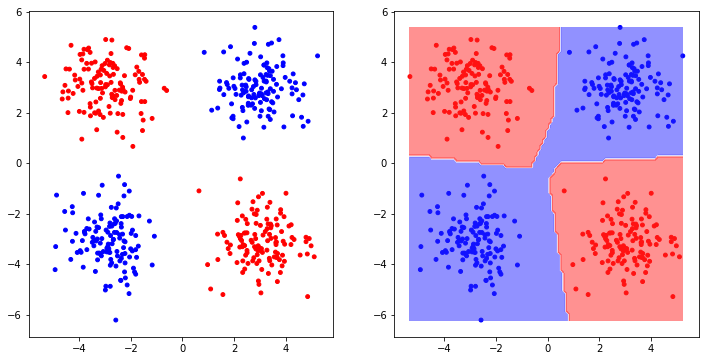

In [46]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=500, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

In [47]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/1000 data_loss:0.00317572 reg_loss:0.00000000 cost:0.00317572
epoch:  100/1000 data_loss:0.00051589 reg_loss:0.00000000 cost:0.00051589
epoch:  200/1000 data_loss:0.00008636 reg_loss:0.00000000 cost:0.00008636
epoch:  300/1000 data_loss:0.00005822 reg_loss:0.00000000 cost:0.00005822
epoch:  400/1000 data_loss:0.00004691 reg_loss:0.00000000 cost:0.00004691
epoch:  500/1000 data_loss:0.00004054 reg_loss:0.00000000 cost:0.00004054
epoch:  600/1000 data_loss:0.00003630 reg_loss:0.00000000 cost:0.00003630
epoch:  700/1000 data_loss:0.00003331 reg_loss:0.00000000 cost:0.00003331
epoch:  800/1000 data_loss:0.00002983 reg_loss:0.00000000 cost:0.00002983
epoch:  900/1000 data_loss:0.00002764 reg_loss:0.00000000 cost:0.00002764
epoch: 1000/1000 data_loss:0.00002616 reg_loss:0.00000000 cost:0.00002616
Acurácia: 99.80%


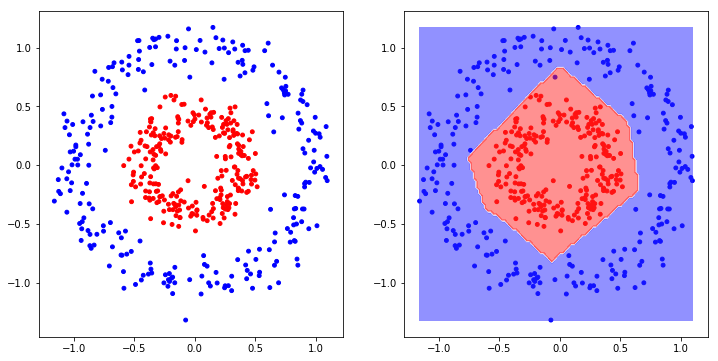

In [48]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

In [49]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/2000 data_loss:0.00901590 reg_loss:0.00000000 cost:0.00901590
epoch:  200/2000 data_loss:0.00169455 reg_loss:0.00000000 cost:0.00169455
epoch:  400/2000 data_loss:0.00159153 reg_loss:0.00000000 cost:0.00159153
epoch:  600/2000 data_loss:0.00151313 reg_loss:0.00000000 cost:0.00151313
epoch:  800/2000 data_loss:0.00143416 reg_loss:0.00000000 cost:0.00143416
epoch: 1000/2000 data_loss:0.00137962 reg_loss:0.00000000 cost:0.00137962
epoch: 1200/2000 data_loss:0.00131174 reg_loss:0.00000000 cost:0.00131174
epoch: 1400/2000 data_loss:0.00119408 reg_loss:0.00000000 cost:0.00119408
epoch: 1600/2000 data_loss:0.00097135 reg_loss:0.00000000 cost:0.00097135
epoch: 1800/2000 data_loss:0.00075613 reg_loss:0.00000000 cost:0.00075613
epoch: 2000/2000 data_loss:0.00062036 reg_loss:0.00000000 cost:0.00062036
Acurácia: 97.50%


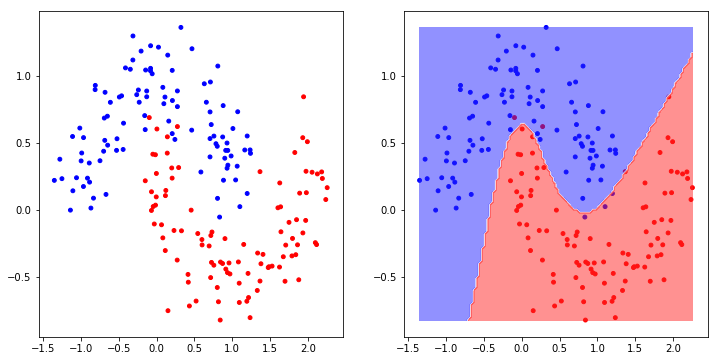

In [51]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=tanh))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=2000, verbose=200)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

In [52]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/5000 data_loss:0.00614292 reg_loss:0.00000000 cost:0.00614292
epoch:  500/5000 data_loss:0.00110910 reg_loss:0.00000000 cost:0.00110910
epoch: 1000/5000 data_loss:0.00058029 reg_loss:0.00000000 cost:0.00058029
epoch: 1500/5000 data_loss:0.00041174 reg_loss:0.00000000 cost:0.00041174
epoch: 2000/5000 data_loss:0.00028411 reg_loss:0.00000000 cost:0.00028411
epoch: 2500/5000 data_loss:0.00016269 reg_loss:0.00000000 cost:0.00016269
epoch: 3000/5000 data_loss:0.00030140 reg_loss:0.00000000 cost:0.00030140
epoch: 3500/5000 data_loss:0.00018517 reg_loss:0.00000000 cost:0.00018517
epoch: 4000/5000 data_loss:0.00022221 reg_loss:0.00000000 cost:0.00022221
epoch: 4500/5000 data_loss:0.00007002 reg_loss:0.00000000 cost:0.00007002
epoch: 5000/5000 data_loss:0.00015151 reg_loss:0.00000000 cost:0.00015151
Acurácia: 99.00%


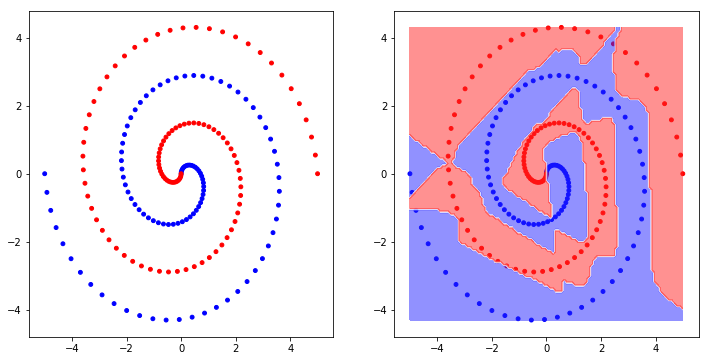

In [64]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=20, activation=tanh, dropout_prob=0.25))
nn.layers.append(Layer(input_dim=20, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=500)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

In [65]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [66]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


epoch:    0/1000 data_loss:0.01273024 reg_loss:0.50146829 cost:0.51419853
epoch:  100/1000 data_loss:0.00122810 reg_loss:0.16263257 cost:0.16386067
epoch:  200/1000 data_loss:0.00106963 reg_loss:0.13900649 cost:0.14007612
epoch:  300/1000 data_loss:0.00093714 reg_loss:0.13752343 cost:0.13846057
epoch:  400/1000 data_loss:0.00083374 reg_loss:0.13956798 cost:0.14040172
epoch:  500/1000 data_loss:0.00074919 reg_loss:0.14292226 cost:0.14367145
epoch:  600/1000 data_loss:0.00068291 reg_loss:0.14566549 cost:0.14634839
epoch:  700/1000 data_loss:0.00062906 reg_loss:0.14824108 cost:0.14887014
epoch:  800/1000 data_loss:0.00058522 reg_loss:0.15051615 cost:0.15110137
epoch:  900/1000 data_loss:0.00054885 reg_loss:0.15262034 cost:0.15316919
epoch: 1000/1000 data_loss:0.00051836 reg_loss:0.15456157 cost:0.15507993
[[ 0.68006277  0.56540647]
 [-0.62527767  0.58632532]]
[[-0.4376976  -0.44720866]
 [-0.28928199  0.70868483]
 [ 0.72693982 -0.26149102]]
Acurácia: 99.67%


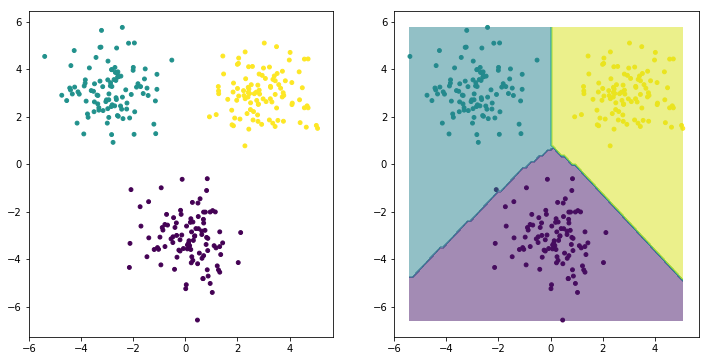

In [68]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu, reg_func=l2_regularization, reg_strength=0.1))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=0.1))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

for layer in nn.layers:
    print(layer.weights)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

In [69]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [70]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


epoch:    0/1000 data_loss:0.01200678 reg_loss:0.00000000 cost:0.01200678
epoch:  100/1000 data_loss:0.00101494 reg_loss:0.00000000 cost:0.00101494
epoch:  200/1000 data_loss:0.00087859 reg_loss:0.00000000 cost:0.00087859
epoch:  300/1000 data_loss:0.00077634 reg_loss:0.00000000 cost:0.00077634
epoch:  400/1000 data_loss:0.00068838 reg_loss:0.00000000 cost:0.00068838
epoch:  500/1000 data_loss:0.00059009 reg_loss:0.00000000 cost:0.00059009
epoch:  600/1000 data_loss:0.00044198 reg_loss:0.00000000 cost:0.00044198
epoch:  700/1000 data_loss:0.00030815 reg_loss:0.00000000 cost:0.00030815
epoch:  800/1000 data_loss:0.00026357 reg_loss:0.00000000 cost:0.00026357
epoch:  900/1000 data_loss:0.00025040 reg_loss:0.00000000 cost:0.00025040
epoch: 1000/1000 data_loss:0.00024609 reg_loss:0.00000000 cost:0.00024609
Acurácia: 97.00%


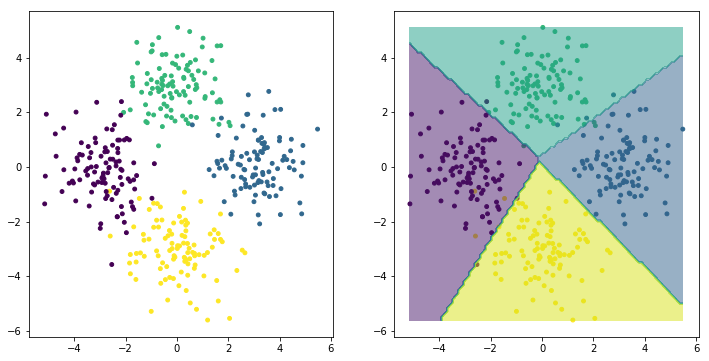

In [71]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

In [72]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [73]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


epoch:    0/1000 data_loss:0.01083792 reg_loss:0.00000000 cost:0.01083792
epoch:  100/1000 data_loss:0.00077685 reg_loss:0.00000000 cost:0.00077685
epoch:  200/1000 data_loss:0.00036000 reg_loss:0.00000000 cost:0.00036000
epoch:  300/1000 data_loss:0.00019924 reg_loss:0.00000000 cost:0.00019924
epoch:  400/1000 data_loss:0.00012481 reg_loss:0.00000000 cost:0.00012481
epoch:  500/1000 data_loss:0.00010074 reg_loss:0.00000000 cost:0.00010074
epoch:  600/1000 data_loss:0.00008663 reg_loss:0.00000000 cost:0.00008663
epoch:  700/1000 data_loss:0.00007756 reg_loss:0.00000000 cost:0.00007756
epoch:  800/1000 data_loss:0.00007107 reg_loss:0.00000000 cost:0.00007107
epoch:  900/1000 data_loss:0.00006634 reg_loss:0.00000000 cost:0.00006634
epoch: 1000/1000 data_loss:0.00006271 reg_loss:0.00000000 cost:0.00006271
Acurácia: 99.20%


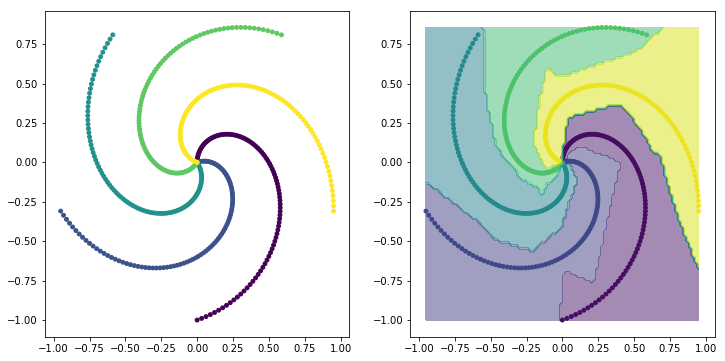

In [74]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [75]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [76]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


epoch:    0/1000 data_loss:0.03443984 reg_loss:0.00000000 cost:0.03443984
epoch:  100/1000 data_loss:0.00473679 reg_loss:0.00000000 cost:0.00473679
epoch:  200/1000 data_loss:0.00370345 reg_loss:0.00000000 cost:0.00370345
epoch:  300/1000 data_loss:0.00317768 reg_loss:0.00000000 cost:0.00317768
epoch:  400/1000 data_loss:0.00283107 reg_loss:0.00000000 cost:0.00283107
epoch:  500/1000 data_loss:0.00258329 reg_loss:0.00000000 cost:0.00258329
epoch:  600/1000 data_loss:0.00239121 reg_loss:0.00000000 cost:0.00239121
epoch:  700/1000 data_loss:0.00223725 reg_loss:0.00000000 cost:0.00223725
epoch:  800/1000 data_loss:0.00211142 reg_loss:0.00000000 cost:0.00211142
epoch:  900/1000 data_loss:0.00200687 reg_loss:0.00000000 cost:0.00200687
epoch: 1000/1000 data_loss:0.00191848 reg_loss:0.00000000 cost:0.00191848
Acurácia: 94.00%


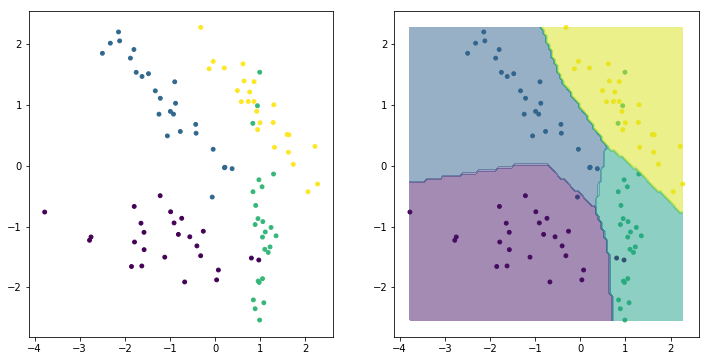

In [77]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [78]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [79]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


epoch:    0/5000 data_loss:0.03099052 reg_loss:0.00000000 cost:0.03099052
epoch:  500/5000 data_loss:0.00174436 reg_loss:0.00000000 cost:0.00174436
epoch: 1000/5000 data_loss:0.00122496 reg_loss:0.00000000 cost:0.00122496
epoch: 1500/5000 data_loss:0.00092872 reg_loss:0.00000000 cost:0.00092872
epoch: 2000/5000 data_loss:0.00077079 reg_loss:0.00000000 cost:0.00077079
epoch: 2500/5000 data_loss:0.00068014 reg_loss:0.00000000 cost:0.00068014
epoch: 3000/5000 data_loss:0.00062305 reg_loss:0.00000000 cost:0.00062305
epoch: 3500/5000 data_loss:0.00058465 reg_loss:0.00000000 cost:0.00058465
epoch: 4000/5000 data_loss:0.00055755 reg_loss:0.00000000 cost:0.00055755
epoch: 4500/5000 data_loss:0.00053770 reg_loss:0.00000000 cost:0.00053770
epoch: 5000/5000 data_loss:0.00052276 reg_loss:0.00000000 cost:0.00052276
Acurácia: 96.00%


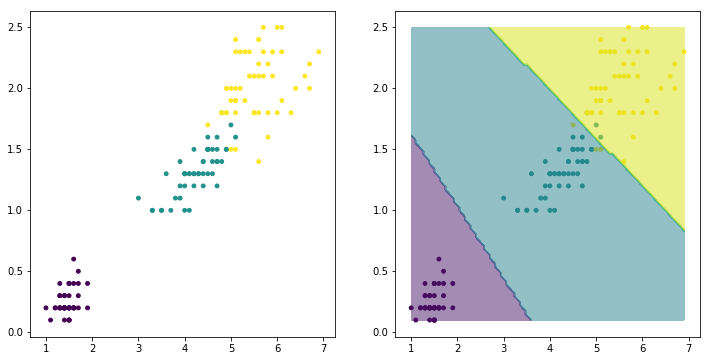

In [84]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=5000, verbose=500)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__TODO__:
- evitar overflow das funções de ativação
- mini-batch SGD
- early_stopping

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```

__NOTAS__:

__Inicialização dos pesos__:
- mostrar a documentação das funções np.random.rand e np.random.randn para mostrar como gerar distribuições na faixa [-limit, limit] e com média zero e certo desvio-padrão.
- mostrar que os métodos de inicialização de pesos ones e random_uniform podem não ser adequados para alguns problemas, como o do espiral binário.

__Regularização__:
- mostrar que a regularização dos pesos nem sempre ajuda. Em alguns casos, como o espiral multiclasse, temos que definir a reg_strength muito pequena. Isto é, estamos dizendo que o valores dos pesos não podem influenciar no custo. Em outras palavras, isso é a mesma coisa que "desligar" a regularização.